In [5]:
from model.model import load_trained_model

model = load_trained_model('picasso_test')

In [11]:
'''
--------
|    x |   <- 50nm deeper than other
|      |
| x    |
--------

5 structures, frame 16 px,
structureX: 1000,3000
structureY: 1000,3000

structure3D: 0,50
ExchangeLabels:1,1
'''

# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/grid_single/grid_single'
dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/grid_pairs/grid_pairs'

In [12]:
import yaml

yaml_file = f'{dirpath}.yaml'

class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

with open(yaml_file, "r") as stream:
    root = yaml.load(stream, Loader=SafeLoaderIgnoreUnknown)
with open(yaml_file, "w") as stream:
    yaml.dump(root, stream)

In [20]:
%load_ext autoreload
%autoreload 2

import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [5,5]

locs = f'{dirpath}_locs.hdf5'
spots = f'{dirpath}_spots.hdf5'
df = pd.read_hdf(locs, 'locs')

f = h5py.File(spots, 'r')
spots = np.array(f['spots'])[:, :, :, np.newaxis]

df['id'] = np.arange(0, df.shape[0])
f.close()

from data.datasets import norm_dataset_from_config, standardise, load_ref_img_and_norm

spots = spots / np.iinfo(np.uint16).max

print(spots.min(), spots.max())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.008346685 0.10792706


(16667, 31, 31, 1)


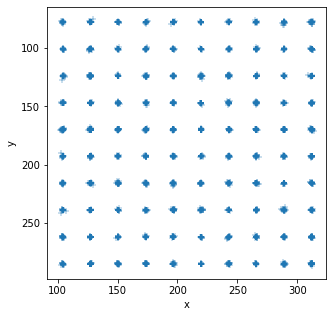

521/521 [==============================] - 2s 4ms/step
204.85732
462.1937 1416.5806


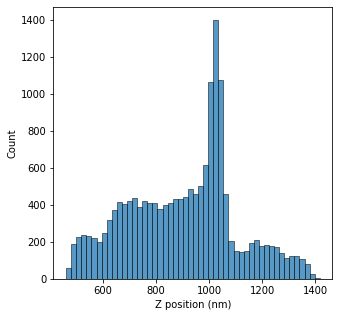

[ 463.15884  466.54922  467.535    471.2041   473.51566  473.62863
  475.99237  478.74185  480.31827  483.51413  484.5917   485.20605
  485.6579   487.80026  487.99817  488.6002   488.92722  493.04272
  494.63998  496.12836  497.45578  498.59808  499.83203  501.63928
  501.9237   501.95642  505.5032   506.3889   506.65042  507.59146
  508.36636  511.3039   511.84525  512.7136   513.475    514.64886
  515.1053   515.97784  516.3957   517.1775   517.25037  517.6106
  518.98334  519.335    519.84863  520.086    520.5987   522.6799
  524.3952   524.53625  525.1551   525.24756  526.4831   527.0834
  527.66626  531.9866   532.61633  535.4073   537.4944   540.3537
  542.0098   546.4408   547.8785   552.5568   554.3432   554.89606
  555.1163   555.43134  562.1328   563.2351   565.2624   565.54285
  568.16394  568.9317   571.6197   572.76544  573.1628   574.4255
  574.7264   584.00464  585.56024  586.9654   593.63525  594.26587
  610.55286  614.377    614.99     615.28265  616.19244  617.5832
 

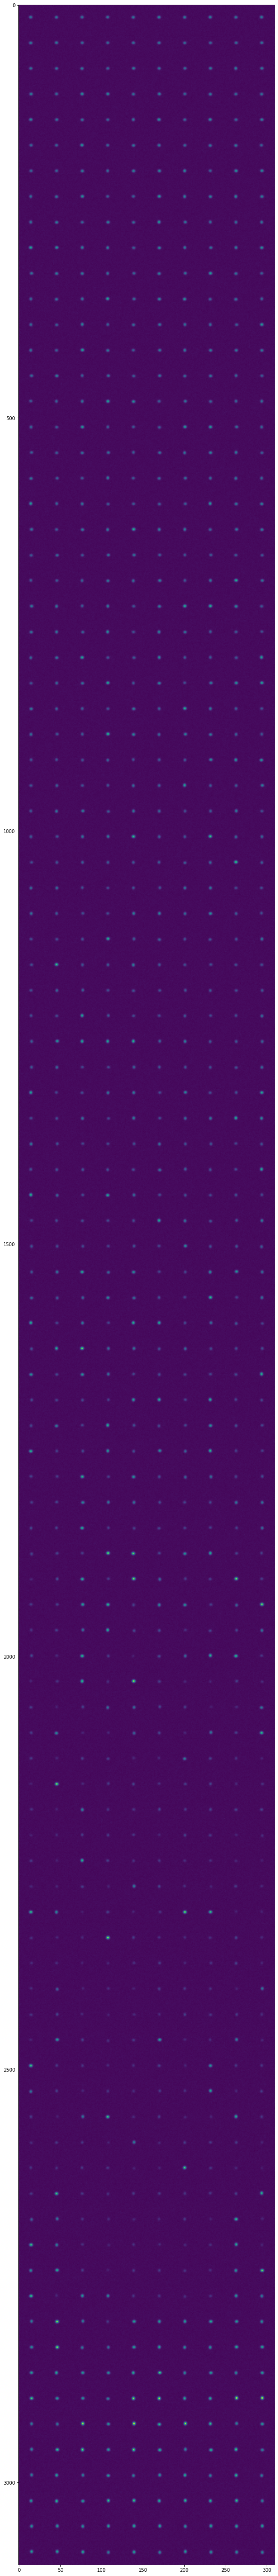

In [21]:
# # Rescale to [-1, 1]
# spots = np.stack([norm_one_one(img) for img in spots])


plt.gca().invert_yaxis()

df['index'] = np.arange(0, df.shape[0])
print(spots.shape)
plt.rcParams['figure.figsize'] = [5, 5]
sns.scatterplot(data=df, x='x', y='y', marker='+')
plt.show()


coords = np.zeros((spots.shape[0], 2))

pred = model.predict((spots, coords)).squeeze()
print(np.std(pred))
df['pred'] = pred
print(pred.min(), pred.max())

plt.rcParams['figure.figsize'] = [5, 5]
sns.histplot(pred, bins=50)
plt.xlabel('Z position (nm)')
plt.show()


sub_imgs = spots[0:1000]
sub_preds = pred[0:1000]
plt.rcParams['figure.figsize'] = [100, 100]
from data.visualise import grid_psfs
print(np.sort(sub_preds.squeeze()))

plt.imshow(grid_psfs(sub_imgs[np.argsort(sub_preds.squeeze())].squeeze()))
plt.show()